# compare the surrogate model using GPR and Random Forest

In [1]:
path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src'
sys.path.append(path_MOASMO)
import sampling
import gp
import NSGA2
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pickle
from MOASMO_parameters import *
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def read_parameter_csv(file_parameter_list):
    df_calibparam = pd.read_csv(file_parameter_list)
    for c in ['Upper', 'Lower', 'Factor', 'Value']:
        if c in df_calibparam.columns:
            if isinstance(df_calibparam.iloc[0][c], str):
                arr = []
                for i in range(len(df_calibparam)):
                    vi = df_calibparam.iloc[i][c]
                    if ',' in vi:
                        arr.append(np.array(vi.split(',')).astype(np.float64))
                    elif '[' in vi:
                        arr.append(np.array(vi.strip('[]').replace('\n', '').split(), dtype=np.float64))
                    else:
                        try:
                            arr.append(np.array([np.float64(vi)]))
                        except:
                            arr.append(np.array([-99999]))
                df_calibparam[c] = arr
    return df_calibparam

In [2]:
# GPR functions
# cross validation of surrogate model using GPR
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

def calculate_rmse(y_true, y_pred):
    """Calculate the Root Mean Squared Error (RMSE) between true values and predicted values."""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse



# Input data

In [3]:
# input data: parameters and objective functions
param_infofile = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/src/parameter/param_ASG_20221206_moasmo.csv'
param_filelist = ['/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_MOASMO/level1_0_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv']
metric_filelist = ['/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_MOASMO/level1_0_MOASMOcalib/ctsm_outputs//iter0_all_metric.csv']


# input data x (parameter sets) and output data y (objective function values)
df_param = pd.concat(map(pd.read_csv, param_filelist))
df_metric = pd.concat(map(pd.read_csv, metric_filelist))
df_info = read_parameter_csv(param_infofile)

param_names = df_info['Parameter'].values # exclude binded parameters
df_param = df_param[param_names]

xlb = np.array([np.nanmean(v) for v in df_info['Lower']])
xub = np.array([np.nanmean(v) for v in df_info['Upper']])

x = df_param.to_numpy()
y = df_metric.to_numpy()

nInput = x.shape[1]
nOutput = y.shape[1]

# compare parameter estimation from different surrogate models

In [4]:
# surrogate model using random forest
sm_rf = RandomForestRegressor()
sm_rf.fit(x, y)

RandomForestRegressor()

In [5]:
# surrogate model using GPR
kernel = Matern(length_scale=1.0, nu=1.5)
sm_gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
sm_gpr.fit(x, y[:,0])


GaussianProcessRegressor(alpha=0.1, kernel=Matern(length_scale=1, nu=1.5))

In [7]:
# optimization using NSGA2
pop = 100
gen = 100
crossover_rate = 0.9
mu = 20
mum = 20

# define hyperparameter
alpha = 1e-3
leng_lb = 1e-3
leng_ub = 1e3
nu = 2.5

N_resample = 20 # number of selected optimal points

bestx_sm_rf, besty_sm_rf, x_sm_rf, y_sm_rf = NSGA2.optimization(sm_rf, nInput, nOutput, xlb, xub, pop, gen, crossover_rate, mu, mum)
D = NSGA2.crowding_distance(besty_sm_rf)
idxr = D.argsort()[::-1][:N_resample]
x_resample_rf = bestx_sm_rf[idxr, :]


# bestx_sm_gpr, besty_sm_gpr, x_sm_gpr, y_sm_gpr = NSGA2.optimization(sm_gpr, nInput, nOutput, xlb, xub, pop, gen, crossover_rate, mu, mum)
# D = NSGA2.crowding_distance(besty_sm_gpr)
# idxr = D.argsort()[::-1][:N_resample]
# x_resample_gpr = bestx_sm_gpr[idxr, :]

In [8]:
# Compare parameter estimates from RF and GPR

# Cross validation

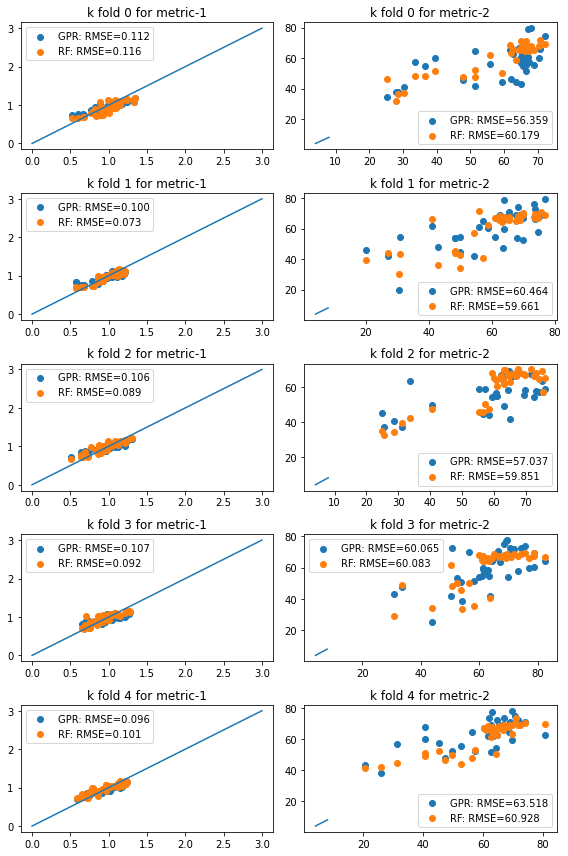

In [12]:
kf = KFold(n_splits=5)
kf.get_n_splits(x)

fig, ax = plt.subplots(5, 2, figsize=[8, 12])
ax = ax.flatten()

for i, (train_index, test_index) in enumerate(kf.split(x)):
    
    scaler = StandardScaler()
    scaler.fit(x[train_index, :])

    x_train = scaler.transform(x[train_index, :])
    y_train = y[train_index, :]
    
    x_test= scaler.transform(x[test_index, :])
    y_test = y[test_index, :]
    

    # kernel = DotProduct() + WhiteKernel()
    # kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    # smi = GaussianProcessRegressor(kernel=kernel)
    kernel = Matern(length_scale=1.0, nu=1.5)
    smi = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
    smi.fit(x_train, y_train[:,0])
    rmse = calculate_rmse(y_test[:,0], smi.predict(x_test))
    ax[i*2].scatter(y_test[:,0], smi.predict(x_test), label=f'GPR: RMSE={rmse:.3f}')
    
    smi = RandomForestRegressor()
    smi.fit(x_train, y_train[:,0])
    rmse = calculate_rmse(y_test[:,0], smi.predict(x_test))
    ax[i*2].scatter(y_test[:,0], smi.predict(x_test), label=f'RF: RMSE={rmse:.3f}')
    
    
    ax[i*2].plot([0, 3], [0, 3])
    ax[i*2].set_title(f'k fold {i} for metric-1')
    
    ax[i*2].legend()
    
    # kernel = DotProduct() + WhiteKernel()
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    smi = GaussianProcessRegressor(kernel=kernel, )
    smi.fit(x_train, y_train[:,1])
    rmse = calculate_rmse(y_test[:,0], smi.predict(x_test))
    ax[i*2+1].scatter(y_test[:,1], smi.predict(x_test), label=f'GPR: RMSE={rmse:.3f}')
    
    smi = RandomForestRegressor()
    smi.fit(x_train, y_train[:,1])
    rmse = calculate_rmse(y_test[:,0], smi.predict(x_test))
    ax[i*2+1].scatter(y_test[:,1], smi.predict(x_test), label=f'RF: RMSE={rmse:.3f}')
    
    ax[i*2+1].plot([4, 8], [4, 8])
    ax[i*2+1].set_title(f'k fold {i} for metric-2')
    
    ax[i*2+1].legend()
    
plt.tight_layout()
plt.show()